In [ ]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
import time
import datetime
import codecs
import random
import wikipedia
import tabulate

from PIL import Image
from os import path

from IPython.display import HTML, display
from IPython.display import Markdown as md
from ipywidgets import *
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

from metrics.api.pageEdits import getFirstDate, getLastDate
from metrics.TimeSpentEditing import TimeSpentEditing
from metrics.ActionsperEdits import ActionsperEdits

from bokeh.plotting import *
from bokeh.io import show
from bokeh.models.widgets import CheckboxGroup
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

plotly.tools.set_credentials_file(username='fkramer', api_key='LmCFXvemFzCfOyuLsP9u')
plotly.tools.set_config_file(world_readable=True,sharing='public')

%store -r userid_input
%store -r username_input
%store -r article_name
%store -r article_id

In [2]:
md('# General Metrics for:  %s'%article_name)

# General Metrics for:  Aluminium

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code."></form>''')

A Jupyter Widget

### Statistics

In [3]:
granularity = 'monthly'

def viewsDF(article_name,granularity):
    start = 19900101
    today = datetime.date.today().strftime("%Y%m%d")
    end =  int(today)
    
    session = requests.session()
    session.auth = ('fkramer', 'unitest123')
    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/%s/%s/%i/%i'%(article_name,granularity,start,end)

    response = session.get(url=url).json()

    df = pd.DataFrame('0', index=range(len(response['items'])), columns=range(2))
    df.columns = ['timestamp', 'views']

    for i in range (0,len(response['items'])):
        timestamp = response['items'][i]['timestamp']
        df.timestamp.iat[i]=timestamp        
        views = response['items'][i]['views']       
        df.views.iat[i]=views
        
    return df

In [4]:
def getWords(article_name):
    # Get all Words from Article
    wikipedia.set_lang("en")
    query = wikipedia.page(article_name.replace("_", " "))
    return query.content

In [5]:
totalViewsM = viewsDF(article_name,granularity='monthly')
totalViewsD = viewsDF(article_name,granularity='daily')
totalWords = getWords(article_name)

In [6]:
req = requests.get("https://xtools.wmflabs.org/api/page/articleinfo/en.wikipedia.org/%s" %(article_name)).json()

session = requests.session()
session.auth = ('fkramer', 'unitest123')
url = "https://www.wikiwho.net/en/api/v1.0.0-beta/rev_ids/page_id/{}/?editor=true&timestamp=true".format(article_id)
res = session.get(url).json()   
Actions_per_Edits = ActionsperEdits(article_id)
TimeSpend = TimeSpentEditing(article_id) 

table = [
    ['Watchers',req['watchers']],
    ['Pageviews',req['pageviews']],
    ['Pageviews Offset',req['pageviews_offset']],
    ['Revisions',req['revisions']],
    ['Editors',req['editors']],
    ['Author',req['author']],
    ['Created',req['created_at']],
    ['Creation Rev',req['created_rev_id']],
    ['Last modified',req['modified_at']],
    ['Last Rev ID',req['last_edit_id']],
    ['Total Views', totalViewsM.views.values.sum()],
    ['Actions per Edits Within 48 Hours',round(Actions_per_Edits.ActionsperEditsWithin48Hour[0],2)],
    ['Actions per Edits After 48 Hours',round(Actions_per_Edits.ActionsperEditsAfter48Hour[0],2)],
    ['Actions per Edits Exactly in 48 Hours',round(Actions_per_Edits.ActionsperEditsExactlyin48Hour[0],2)],
    ['Sessions Within  48 Hours',TimeSpend.SessionsWithin48Hours.item()],
    ['Sessions After 48 Hours',TimeSpend.SessionsAfter48Hours.item()],
    ['Sessions Exactly in 48 Hours',TimeSpend.SessionsExactlyin48Hours.item()]    
       ]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

A Jupyter Widget

### Article Structure

In [7]:
req = requests.get("https://xtools.wmflabs.org/api/page/prose/en.wikipedia.org/%s" %(article_name)).json()

table = [
    ['Characters',req['characters']],
    ['Words',req['words']],
    ['References',req['references']],
    ['Unique References',req['unique_references']],
    ['Sections',req['sections']]
       ]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

A Jupyter Widget

### Most common words

In [8]:
allWords = pd.DataFrame(Counter(getWords(article_name).split()).most_common())
allWords = allWords.rename(columns={0:'token'}).rename(columns={1:'frequency'})

In [10]:
source = ColumnDataSource(allWords)

columns = [
        TableColumn(field='token', title='Token'),
        TableColumn(field='frequency', title="Frequency")]

data_table = DataTable(source=source, columns=columns, width=800, height=300)
output_notebook()
show(widgetbox(data_table))

Loading BokehJS ...

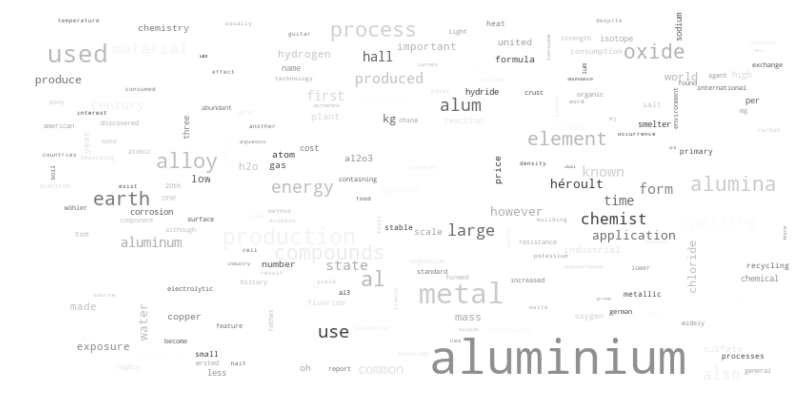

In [11]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


text = getWords(article_name)

wc = WordCloud(width=800, height=400,background_color='white',max_font_size = 50,collocations=False).generate(text.lower())

color_to_words = {}

default_color = 'grey'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)
wc.recolor(color_func=grouped_color_func)

# Plot
plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Article Views

### Article Views per Periode

In [12]:
df4 = viewsDF(article_name,granularity)

for i in range (0,len(df4)):
    timestamp = df4.timestamp[i]
    timestamp = str(timestamp)[:8]
    df4.timestamp.iat[i]=timestamp
    
df4['timestamp']= pd.to_datetime(df4['timestamp'])    
list_granularity = ['monthly','daily']
listTimestamp = list(df4.timestamp)

In [14]:
def f(begin,end,granularity):
    df4 = viewsDF(article_name,granularity)
    
    for i in range (0,len(df4)):
        timestamp = df4.timestamp[i]
        timestamp = str(timestamp)[:8]
        df4.timestamp.iat[i]=timestamp
    df4['timestamp']= pd.to_datetime(df4['timestamp'])
    
    if begin<end or begin == end:
        variable = 0
        
    elif begin>end:
        variable = end
        end = begin
        begin = variable
    else:
        variable = 1
        print('Can not be the case!')
        
    filteredDF = df4[(df4.timestamp >= begin) &(df4.timestamp <= end)]
    
    ## Show Statistics
    
    print('')
    print('--------------------')
    print('Statistics')
    print('--------------------')
    print('Total Amount of views within timeline: {}'.format(filteredDF['views'].sum()))
    print('Avg.  Amount of views within timeline: {}'.format(filteredDF['views'].mean()))
    print('Max.  Amount of views within timeline: {}'.format(filteredDF['views'].max()))
    print('Min.  Amount of views within timeline: {}'.format(filteredDF['views'].min()))
    
    ## Plot Graph
    
    views = list(filteredDF.views)
    month = list(filteredDF.timestamp)

    trace1 = go.Scatter(
        x = month,y = views,
        mode = 'lines+markers',name = 'Adds',
        marker = dict(color = 'rgba(0, 128, 43, .8)')
        )

    layout= go.Layout(hovermode= 'closest',
        xaxis= dict(title= 'Month',ticklen= 5,zeroline= True,gridwidth= 2),
        yaxis=dict(title= 'Actions',ticklen= 5,gridwidth= 2),
        showlegend= True)

    data = [trace1]

    plotly.offline.init_notebook_mode(connected=True)
    plotly.offline.iplot({"data": data,"layout": layout})
    
a = interact(f,begin=listTimestamp,end=sorted(listTimestamp, reverse=True),granularity=list_granularity)

A Jupyter Widget